In [118]:
import os
import numpy as np
import scanpy as sc
import pandas as pd

path = "/home/olle/PycharmProjects/LODE/workspace/cell_oct_data"

cell_pd = pd.read_csv(os.path.join(path, "feature_statistics.csv"))

In [119]:
# create adata object
var_names = ["0", "1", "2", "3","4","5","6","7","8","9","10","11","12","13","14", "15"]

X = np.array(cell_pd[var_names])

obs_id = cell_pd.id
obs_cls = cell_pd.id.str.split("-", expand=True)[0]


adata = sc.AnnData(X=X)
adata.obs["obs_id"] = obs_id.values.tolist()
adata.obs["obs_cls"] = obs_cls.values.tolist()
adata.var["var_name"] = var_names

In [160]:
adata.obs

,obs_id,obs_cls,leiden
0,NORMAL-9053621-1.jpeg,NORMAL,12
1,NORMAL-5324912-1.jpeg,NORMAL,12
2,NORMAL-5246808-2.jpeg,NORMAL,0
3,NORMAL-5246808-1.jpeg,NORMAL,0
4,NORMAL-5193994-1.jpeg,NORMAL,12
...,...,...,...
83996,DRUSEN-1193659-1.jpeg,DRUSEN,27
83997,DRUSEN-1173253-1.jpeg,DRUSEN,13
83998,DRUSEN-1112835-1.jpeg,DRUSEN,3
83999,DRUSEN-1083159-1.jpeg,DRUSEN,25


### Preprocessing

In [120]:
# outlier filtering, remove any images with less 2 then 1000

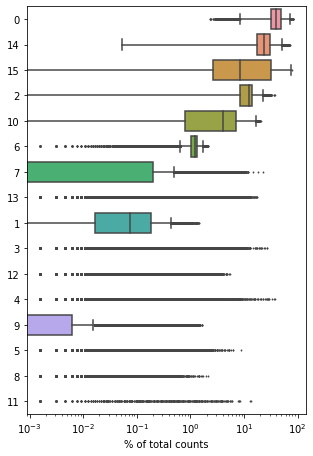

In [121]:
sc.pl.highest_expr_genes(adata, log=True)

... storing 'obs_id' as categorical
... storing 'obs_cls' as categorical


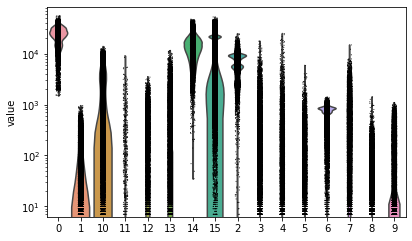

In [122]:
sc.pl.violin(adata, var_names, log=True)

In [123]:
adata = adata[adata.X[:, 2] > 1000]

In [124]:
# Log and norm data

In [125]:
sc.pp.log1p(adata)

/home/olle/miniconda3/envs/spatial_tools/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:297: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if isinstance(data, AnnData) and data.isview:
/home/olle/miniconda3/envs/spatial_tools/lib/python3.6/site-packages/scanpy/_utils.py:341: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:
/home/olle/miniconda3/envs/spatial_tools/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


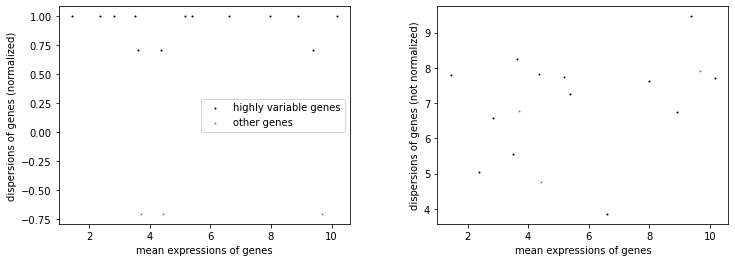

In [126]:
sc.pp.highly_variable_genes(adata, min_mean=0.000125, max_mean=10000, min_disp=0.5)
sc.pl.highly_variable_genes(adata)


In [127]:
sc.pp.scale(adata, max_value=10)


/home/olle/miniconda3/envs/spatial_tools/lib/python3.6/site-packages/scanpy/_utils.py:341: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:


In [128]:
### PCA analysis

In [129]:
sc.tl.pca(adata,n_comps=12, svd_solver='arpack')


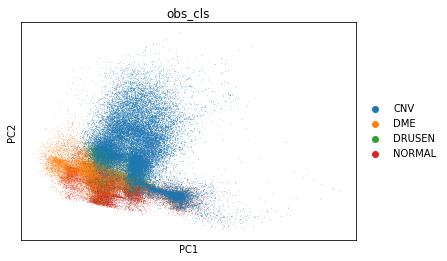

In [130]:
sc.pl.pca(adata, color='obs_cls')


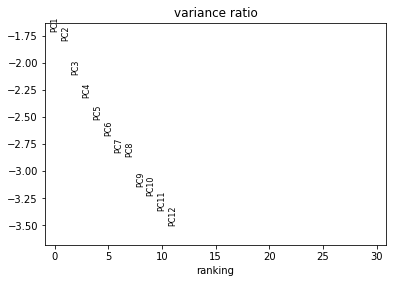

In [131]:
sc.pl.pca_variance_ratio(adata, log=True)


In [132]:
##### compte neighbour hood graph

In [133]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

/home/olle/miniconda3/envs/spatial_tools/lib/python3.6/site-packages/scanpy/neighbors/__init__.py:104: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:  # we shouldn't need this here...
/home/olle/miniconda3/envs/spatial_tools/lib/python3.6/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/olle/miniconda3/envs/spatial_tools/lib/python3.6/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities


In [134]:
sc.tl.umap(adata)

/home/olle/miniconda3/envs/spatial_tools/lib/python3.6/site-packages/scanpy/tools/_umap.py:144: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


<Figure size 1440x720 with 0 Axes>

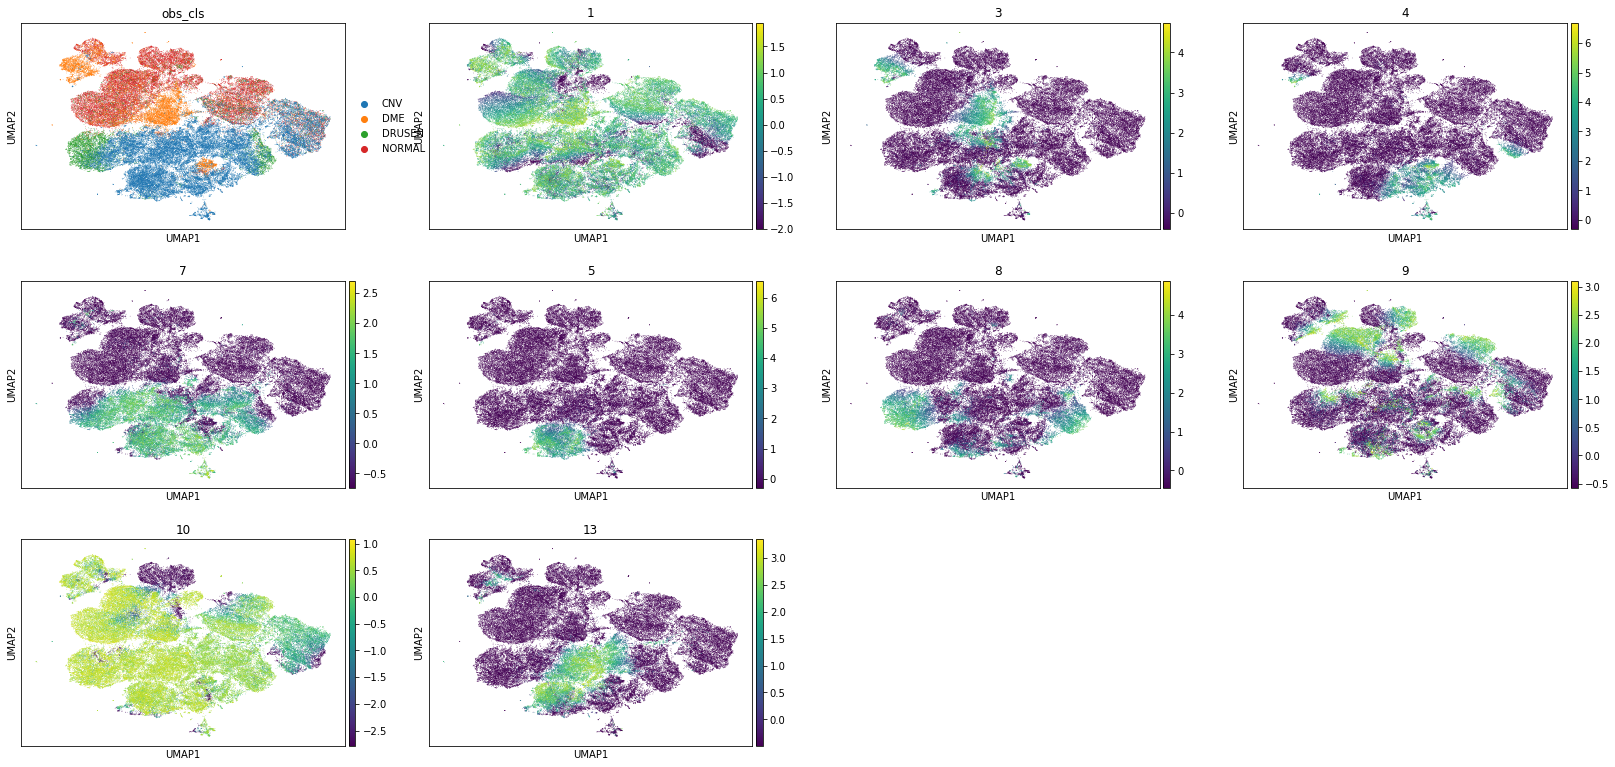

In [162]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sc.pl.umap(adata, color=['obs_cls', "1", "3", "4", "7", "5", "8", "9", "10", "13"])

In [ ]:
color=['obs_cls', "1", "3", "4", "7", "5", "8", "9", "13"]

In [136]:
#### Clustering

In [ ]:
sc.tl.leiden(adata)
sc.tl.louvain(adata)
sc.tl.paga(adata)

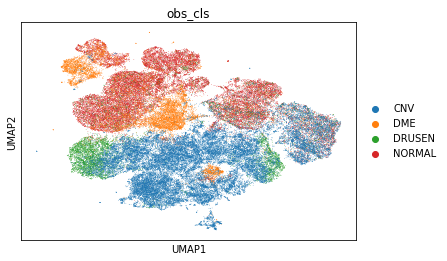

In [165]:
sc.pl.umap(adata, projection="2d", color=['obs_cls'])

In [139]:
#### Feature expression significance

/home/olle/miniconda3/envs/spatial_tools/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:252: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


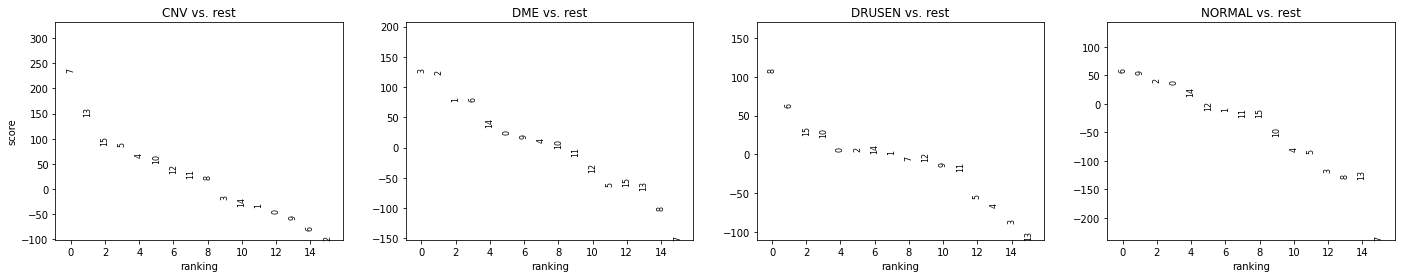

In [140]:
sc.tl.rank_genes_groups(adata, 'obs_cls', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

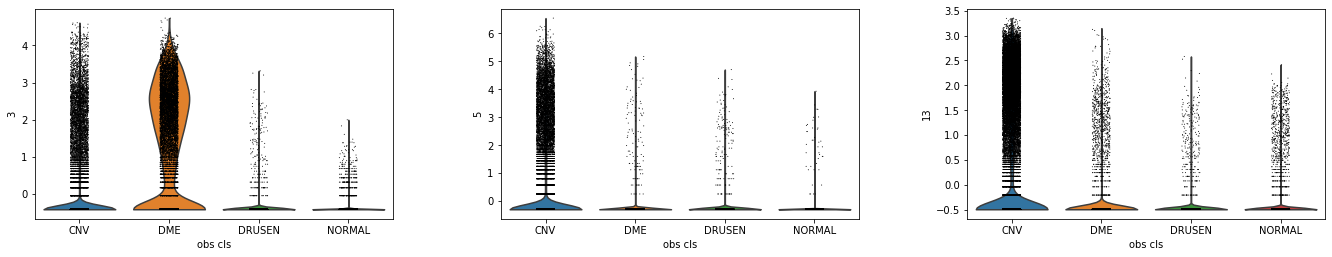

In [141]:
sc.pl.violin(adata, ["3", "5", "13"], groupby='obs_cls')


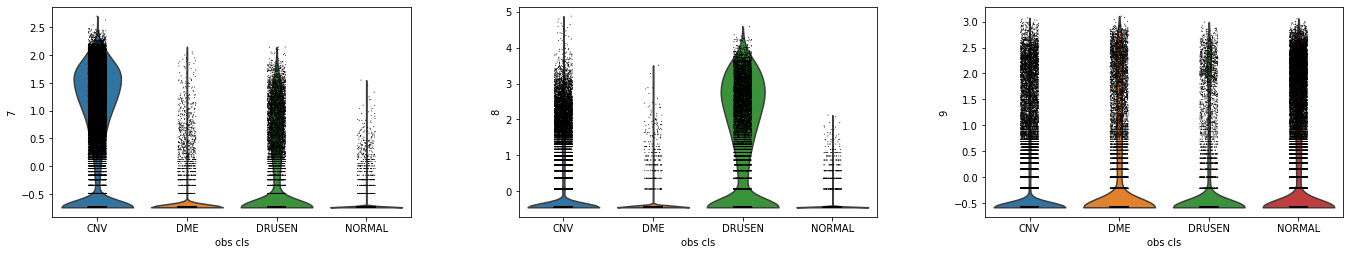

In [142]:
sc.pl.violin(adata, [ "7", "8", "9"], groupby='obs_cls')

In [ ]:
#### Self labeling

In [ ]:
confusion_matrix = np.zeros((num_classes, num_classes))

# For each class.
for class_idx in range(num_classes):
    # Consider 10 examples.
    example_idxs = class_idx_to_test_idxs[class_idx][:10]
    for y_test_idx in example_idxs:
        # And count the classes of its near neighbours.
        for nn_idx in near_neighbours[y_test_idx][:-1]:
            nn_class_idx = y_test[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1

# Display a confusion matrix.
labels = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
plt.show()

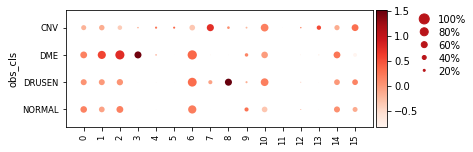

In [143]:
sc.pl.dotplot(adata, adata.var_names, groupby='obs_cls');

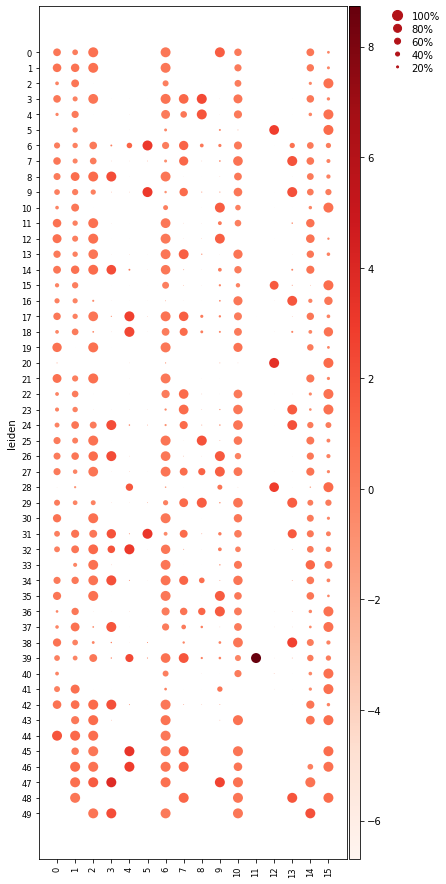

In [144]:
sc.pl.dotplot(adata, adata.var_names, groupby='leiden');

In [145]:
# normalize
X_norm = sc.pp.normalize_total(adata, target_sum=1, inplace=False)['X']

In [146]:
X_norm.shape

(83704, 16)